# Generate Figures for Word2Vec Year Models

The goal of this notebook is to observe how words are shifting through time since 2000. The caveat here is that words have to been present within all time periods in order to be present for this task. Ideally words to be examined so far are: 'expression', 'are', 'interleukin-18', '95%ci', and 'p53'.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pickle

from msp_tsne import MultiscaleParametricTSNE
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow as tf
from tensorflow import keras
import tqdm

from biovectors_modules.plot_helper import (
    plot_local_global_distances,
    plot_token_timeline,
    plot_wordcloud_neighbors,
    plot_wordcloud_neighbors_gif,
)
from biovectors_modules.word2vec_analysis_helper import (
    generate_timeline,
    get_neighbors,
    project_token_timeline,
    window,
)

Using TensorFlow backend.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

# Load Models to Observe Changes

## Load Aligned Word Vectors

In [2]:
aligned_models = pickle.load(open("output/aligned_word_vectors.pkl", "rb"))

In [3]:
year_comparison_dict = {
    "_".join(comparison_file.stem.split("_")[0:2]): (
        pd.read_csv(str(comparison_file), sep="\t")
    )
    for comparison_file in (list(Path("output/year_distances").rglob("*tsv")))
}
list(year_comparison_dict.keys())[0:3]

['2005_2006', '2019_2020', '2016_2017']

In [4]:
year_comparison_dict["2007_2008"].sort_values("global_dist")

,token,global_dist,local_dist,shift
14237,zusammenfassung,2.220446e-16,0.000000,2.220446e-16
12078,sich,1.618271e-01,0.013131,1.486963e-01
4864,einer,1.669384e-01,0.013335,1.536031e-01
14122,wird,1.710061e-01,0.011938,1.590684e-01
4863,eine,1.779562e-01,0.016018,1.619387e-01
...,...,...,...,...
6287,guarded,9.961253e-01,0.600686,3.954390e-01
5957,fungicides,1.024444e+00,0.793797,2.306465e-01
2431,bpb,1.040094e+00,0.743780,2.963145e-01
5579,farnesylation,1.050450e+00,1.122749,-7.229966e-02


## Train TSNE Model to Project Time Shifts into Two Dimensional Space

The goal here is to train a TSNE model that projects all words from 2000 to 2020 into a two dimensional space. Allows one to visually track how a word vector is shifting through time.

In [5]:
word_models_stacked = np.vstack(list(aligned_models.values())[:-1])
file_name = "output/2000_2020_model.h5"

In [6]:
if not Path(file_name).exists():
    tf.random.set_random_seed(100)
    np.random.seed(100)
    model = MultiscaleParametricTSNE(n_iter=300)
    model.fit(word_models_stacked)
    keras.models.save_model(model._model, file_name)
else:
    model = MultiscaleParametricTSNE(n_iter=300)
    model._build_model(300, 2)
    model._model.load_weights(file_name)

# Observe Diachronic Vector Changes

Global distance measures how far a word has moved within semantic space. This measure captures how words change globally across time periods. The greater the distance the more semantic change a word has been subjected towards.
The word clouds depict the neighbors for each word vector. The size for each token  appears to be different but size doesn't matter in this case. Each word has equal weighting.

## Are

In [7]:
token_timeline_df = generate_timeline(year_comparison_dict, "are")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
1803,are,0.233674,0.032151,0.201523,2005_2006
1803,are,0.483105,0.127971,0.355134,2019_2020
1803,are,0.335910,0.065448,0.270462,2016_2017
1803,are,0.342512,0.080005,0.262507,2007_2008
1803,are,0.235155,0.028710,0.206445,2004_2005


In [8]:
token_timeline_low_dim_df = project_token_timeline(
    "are", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,3.873529,5.614344,2020,are,main
1,-0.393960,3.781660,2020,is,neighbor
2,2.803962,-1.715350,2020,were,neighbor
3,-1.682087,4.454685,2020,remain,neighbor
4,-0.112647,4.521511,2020,exist,neighbor


In [9]:
global_distance, local_distance = plot_local_global_distances(token_timeline_df, "are")

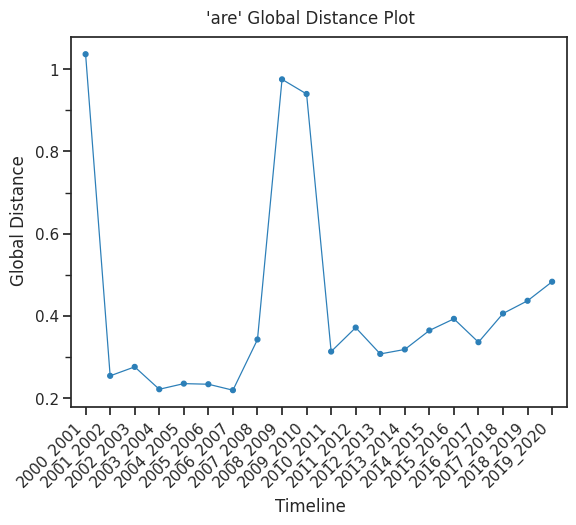

<ggplot: (8786185131626)>

In [10]:
global_distance

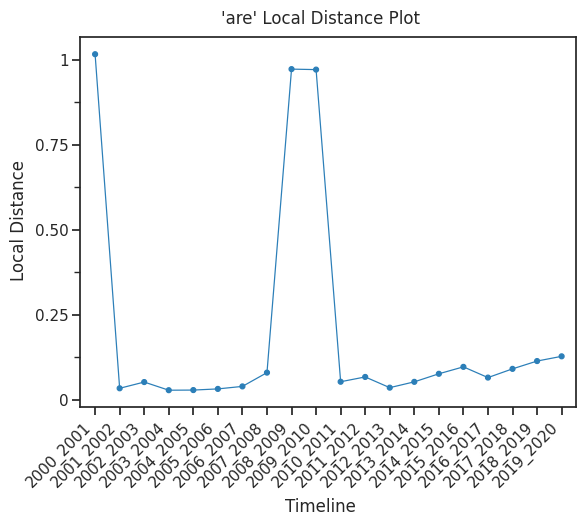

<ggplot: (8786160919644)>

In [11]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/are_time_plot.png


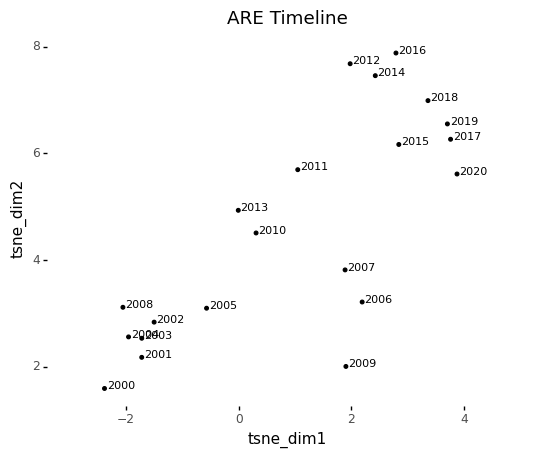

<ggplot: (8786152904147)>


In [12]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/figures/are_time_plot.png")
print(g)

In [13]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/are.gif"
)

![are gif here](output/wordcloud_plots/are.gif)

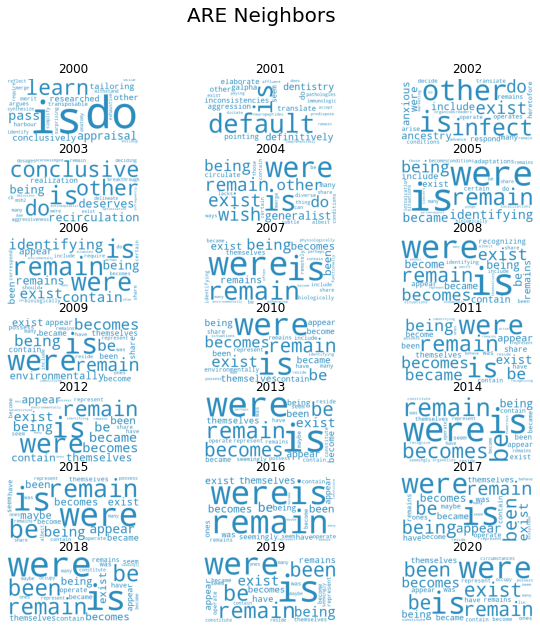

In [14]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/are.png"
)

## Expression

In [15]:
token_timeline_df = generate_timeline(year_comparison_dict, "expression")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
5468,expression,0.257099,0.038613,0.218485,2005_2006
5468,expression,0.366786,0.064503,0.302283,2019_2020
5468,expression,0.338127,0.059178,0.278949,2016_2017
5468,expression,0.315214,0.064721,0.250493,2007_2008
5468,expression,0.300907,0.052331,0.248576,2004_2005


In [16]:
token_timeline_low_dim_df = project_token_timeline(
    "expression", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,3.513293,1.874198,2020,expression,main
1,3.493994,1.711817,2020,expressions,neighbor
2,3.808232,2.457955,2020,overexpression,neighbor
3,2.142848,1.728111,2020,immunoreactivity,neighbor
4,2.561741,3.371302,2020,upregulation,neighbor


In [18]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, "expression"
)

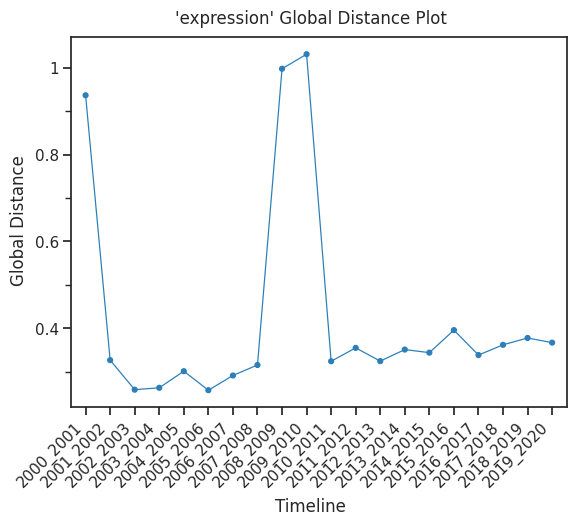

<ggplot: (-9223363250701860776)>

In [19]:
global_distance

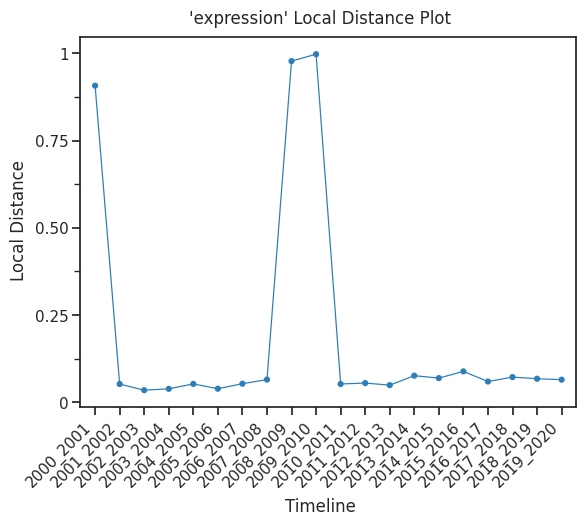

<ggplot: (8786145116841)>

In [20]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/expression_time_plot.png


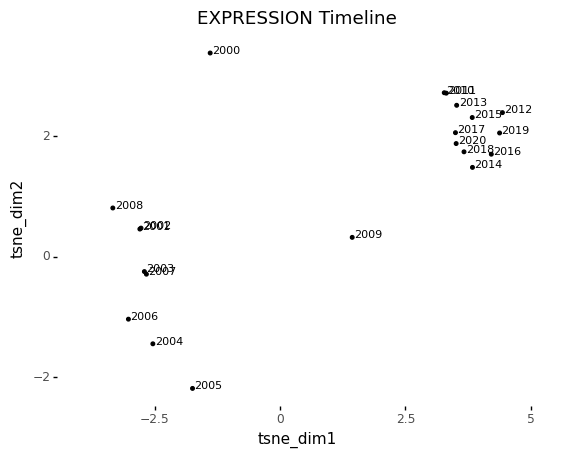

<ggplot: (8786152557688)>


In [21]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/figures/expression_time_plot.png")
print(g)

In [22]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/expression.gif"
)

![expression gif here](output/wordcloud_plots/expression.gif)

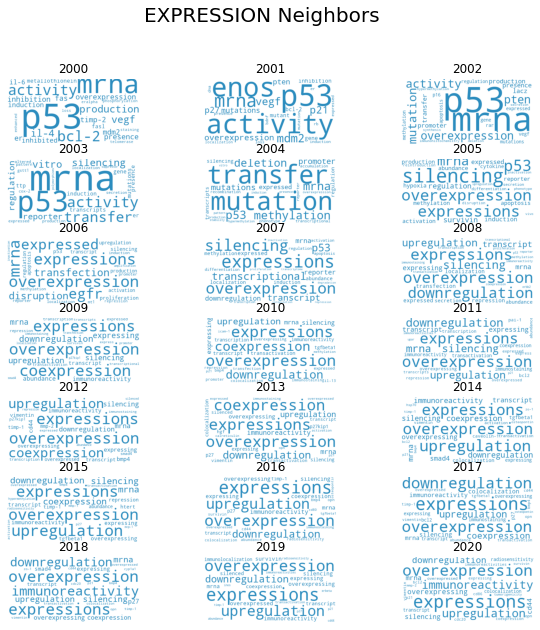

In [23]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/expression.png"
)

## 95%ci

In [24]:
token_timeline_df = generate_timeline(year_comparison_dict, "95%ci")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
1013,95%ci,0.218407,0.022852,0.195555,2005_2006
1013,95%ci,0.491218,0.140781,0.350437,2019_2020
1013,95%ci,0.396221,0.090238,0.305984,2016_2017
1013,95%ci,0.277847,0.037513,0.240333,2007_2008
1013,95%ci,0.201835,0.021949,0.179886,2004_2005


In [25]:
token_timeline_low_dim_df = project_token_timeline(
    "95%ci", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,-1.795989,-0.022887,2020,95%ci,main
1,-3.523857,0.321194,2020,1.61,neighbor
2,-2.831790,-0.112421,2020,ci,neighbor
3,-2.461467,1.133739,2020,1.81,neighbor
4,-2.838907,0.781190,2020,1.71,neighbor


In [26]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="95%ci"
)

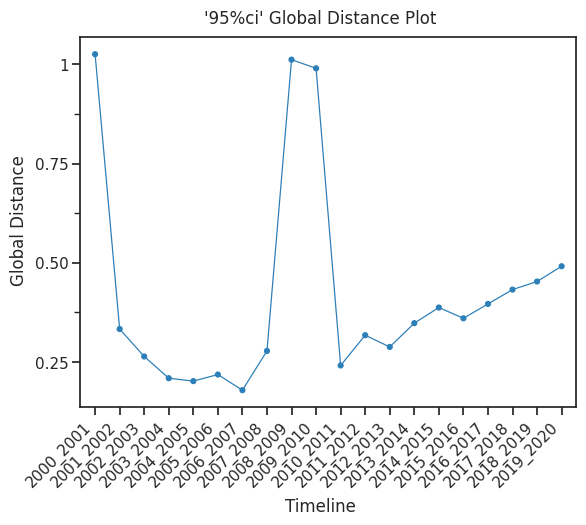

<ggplot: (8786152844457)>

In [27]:
global_distance

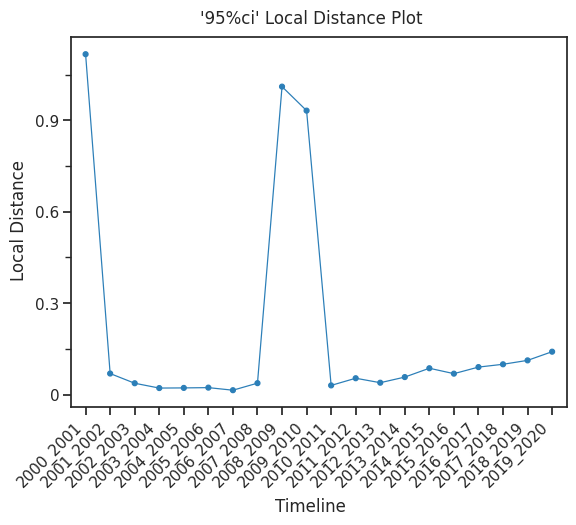

<ggplot: (8786152717632)>

In [28]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/95_ci_time_plot.png


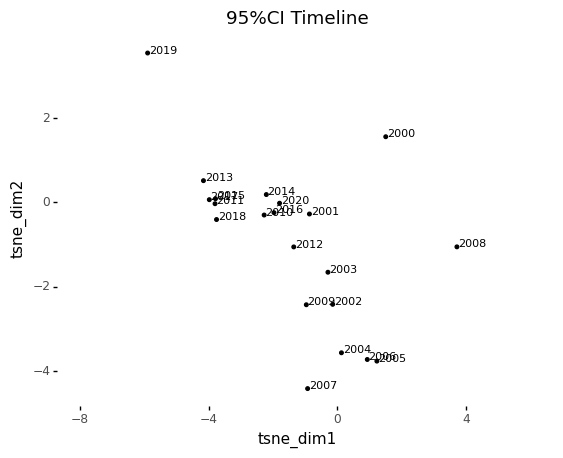

<ggplot: (8786144212968)>


In [29]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/figures/95_ci_time_plot.png")
print(g)

In [30]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/95%ci.gif"
)

![95%ci gif here](output/wordcloud_plots/95%ci.gif)

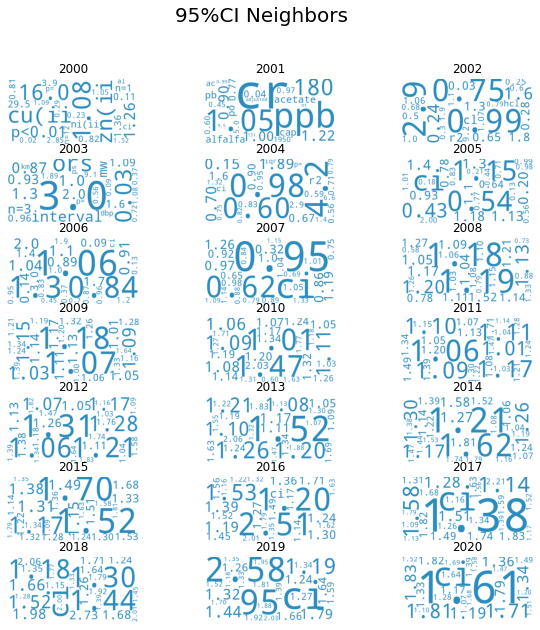

In [31]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/95%ci.png"
)

## interleukin-18

In [32]:
token_timeline_df = generate_timeline(year_comparison_dict, "interleukin-18")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
7355,interleukin-18,1.082164,1.192064,-0.109900,2005_2006
7355,interleukin-18,0.550143,0.122424,0.427719,2019_2020
7355,interleukin-18,0.520146,0.105651,0.414495,2016_2017
7355,interleukin-18,0.574558,0.146061,0.428498,2007_2008
7355,interleukin-18,1.186873,1.562526,-0.375653,2004_2005


In [33]:
token_timeline_low_dim_df = project_token_timeline(
    "interleukin-18", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,0.977388,2.060864,2020,interleukin-18,main
1,2.392112,2.119255,2020,interleukin-1beta,neighbor
2,3.060033,1.948739,2020,il-18,neighbor
3,2.591735,2.175236,2020,mcp-1,neighbor
4,1.625653,2.134389,2020,interleukin-8,neighbor


In [34]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="interleukin-18"
)

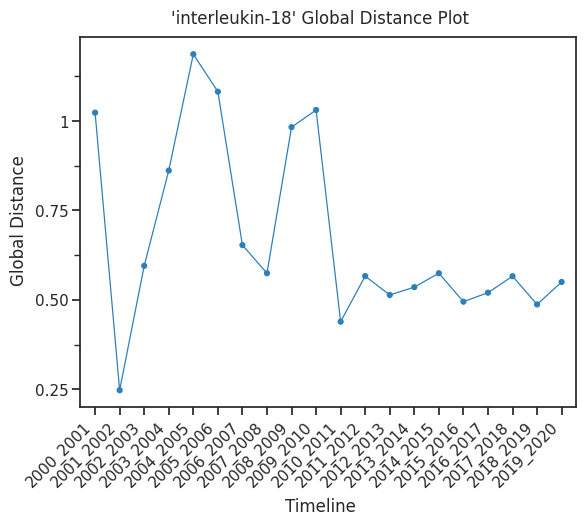

<ggplot: (8786152870583)>

In [35]:
global_distance

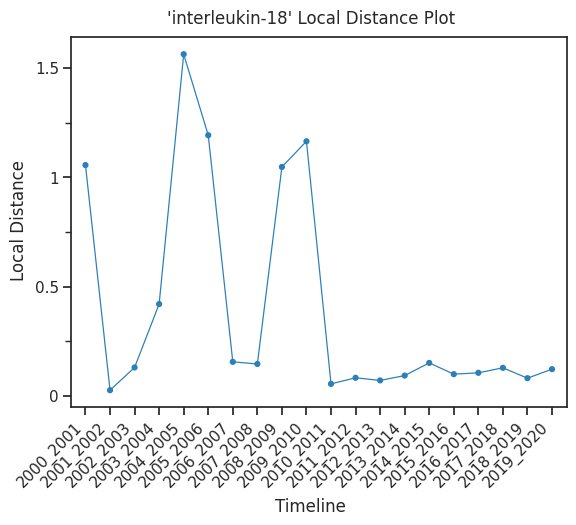

<ggplot: (8786144149964)>

In [36]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/interleukin18_time_plot.png


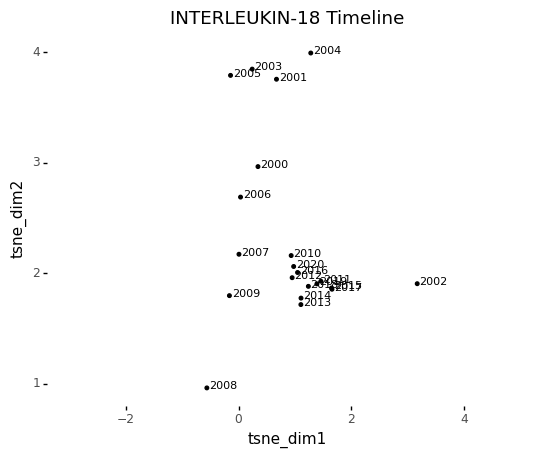

<ggplot: (-9223363250710172356)>


In [37]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/figures/interleukin18_time_plot.png")
print(g)

In [38]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/interleukin-18.gif"
)

![interleukin-18 gif here](output/wordcloud_plots/interleukin-18.gif)

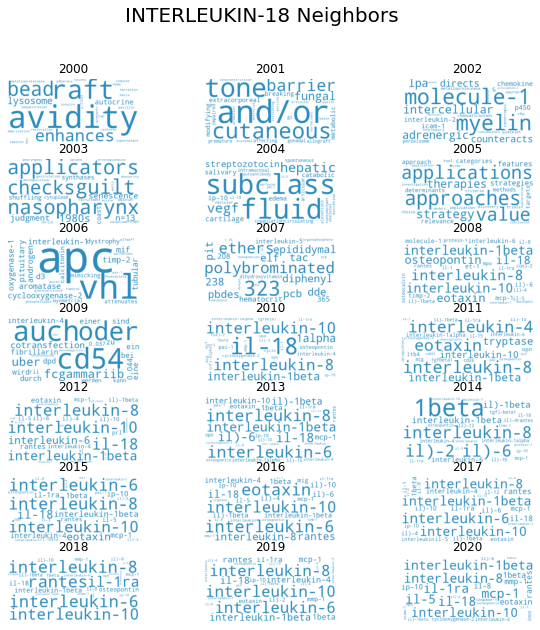

In [39]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/interleukin_18.png"
)

## p53

In [40]:
token_timeline_df = generate_timeline(year_comparison_dict, "p53")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
9680,p53,0.238363,0.028952,0.209411,2005_2006
9680,p53,0.461755,0.105572,0.356183,2019_2020
9680,p53,0.491660,0.112357,0.379303,2016_2017
9680,p53,0.376770,0.065517,0.311253,2007_2008
9680,p53,0.306402,0.041147,0.265254,2004_2005


In [41]:
token_timeline_low_dim_df = project_token_timeline(
    "p53", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,2.693388,2.293756,2020,p53,main
1,2.631979,2.412074,2020,pten,neighbor
2,2.784699,2.252802,2020,p21,neighbor
3,2.212653,2.512582,2020,mdm2,neighbor
4,2.339630,2.289491,2020,smad4,neighbor


In [42]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="p53"
)

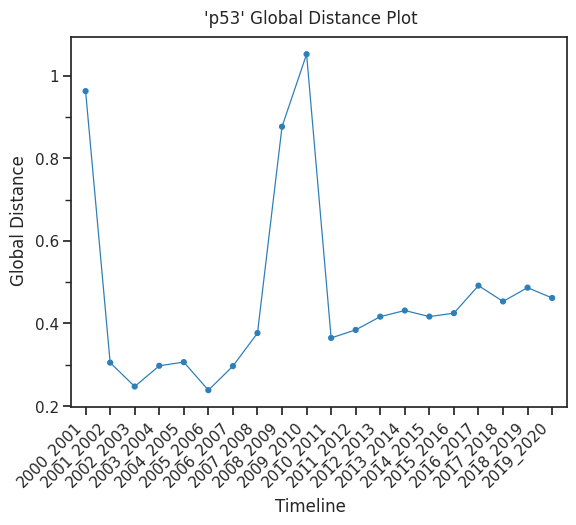

<ggplot: (8786145177352)>

In [43]:
global_distance

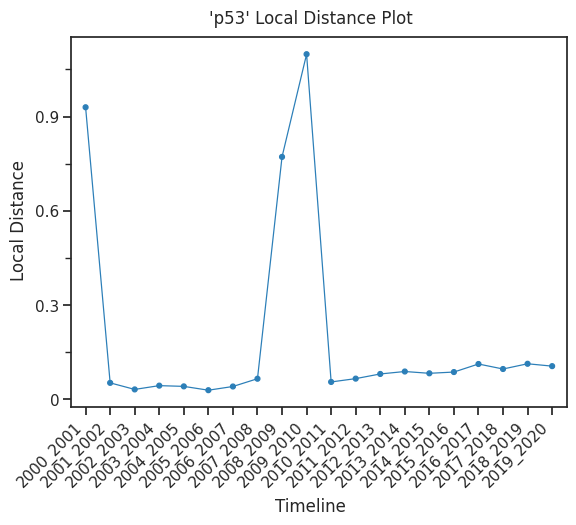

<ggplot: (-9223363250709610601)>

In [44]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/p53_time_plot.png


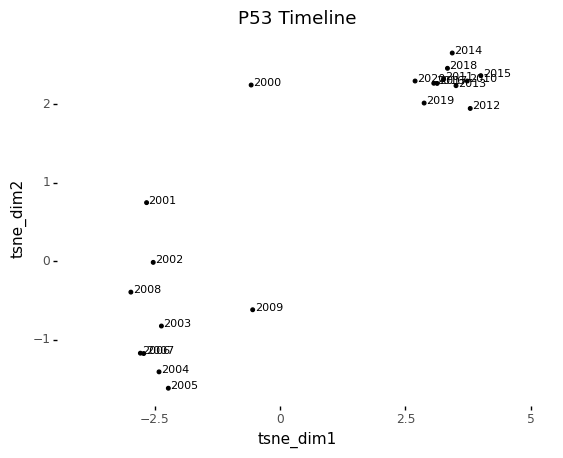

<ggplot: (-9223363250710623772)>


In [45]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/figures/p53_time_plot.png")
print(g)

In [46]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/p53.gif"
)

![p53 gif here](output/wordcloud_plots/p53.gif)

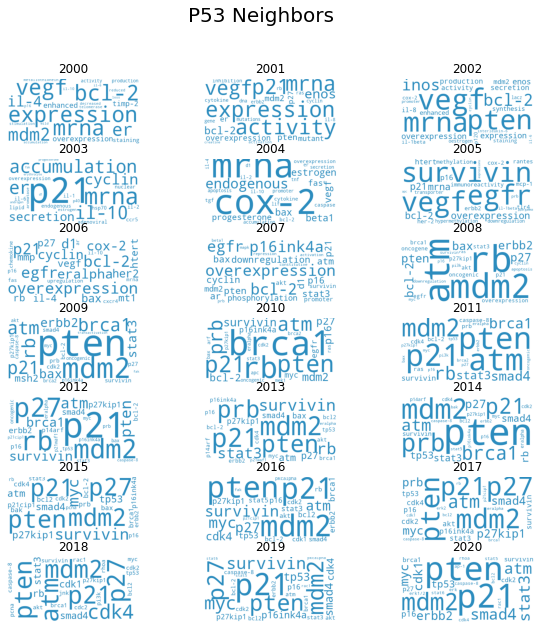

In [47]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/p53.png"
)

## Cystic

In [48]:
token_timeline_df = generate_timeline(year_comparison_dict, "cystic")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
3953,cystic,0.361800,0.069966,0.291834,2005_2006
3953,cystic,0.511271,0.067681,0.443591,2019_2020
3953,cystic,0.482348,0.067794,0.414554,2016_2017
3953,cystic,0.399508,0.054083,0.345425,2007_2008
3953,cystic,0.323130,0.050907,0.272223,2004_2005


In [49]:
token_timeline_low_dim_df = project_token_timeline(
    "cystic", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,0.067216,0.666620,2020,cystic,main
1,0.503567,0.075462,2020,retroperitoneal,neighbor
2,0.811270,0.357080,2020,nodular,neighbor
3,0.670041,0.558174,2020,pleomorphic,neighbor
4,0.554788,0.812157,2020,polypoid,neighbor


In [50]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="cystic"
)

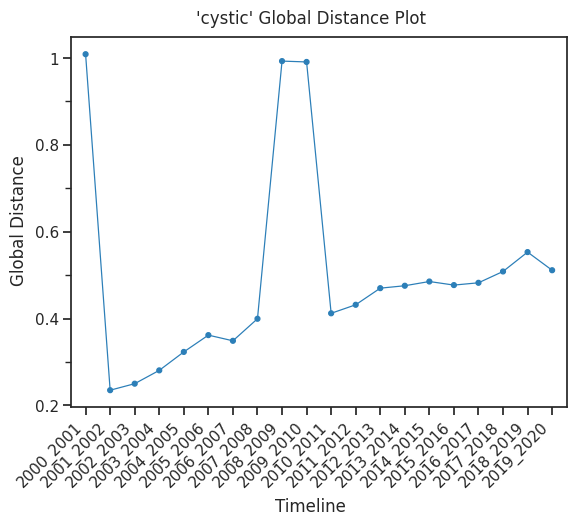

<ggplot: (8786144524643)>

In [51]:
global_distance

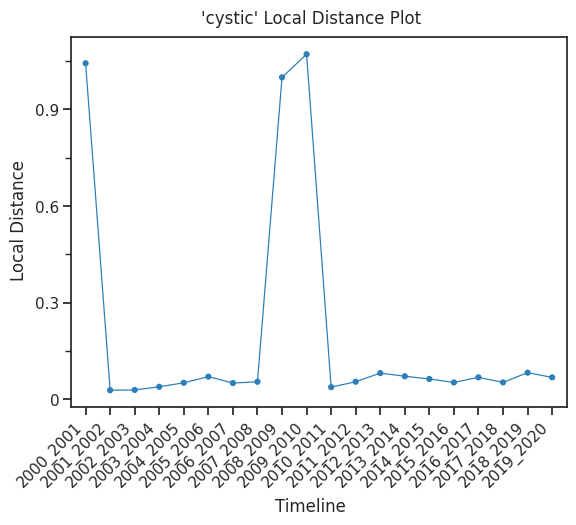

<ggplot: (8786144584070)>

In [52]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/cystic_time_plot.png


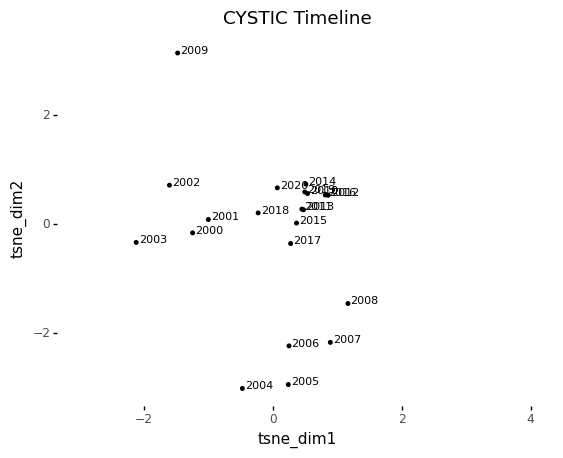

<ggplot: (-9223363250701769405)>


In [53]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/figures/cystic_time_plot.png")
print(g)

In [54]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/cystic.gif"
)

![cystic_gif here](output/wordcloud_plots/cystic.gif)

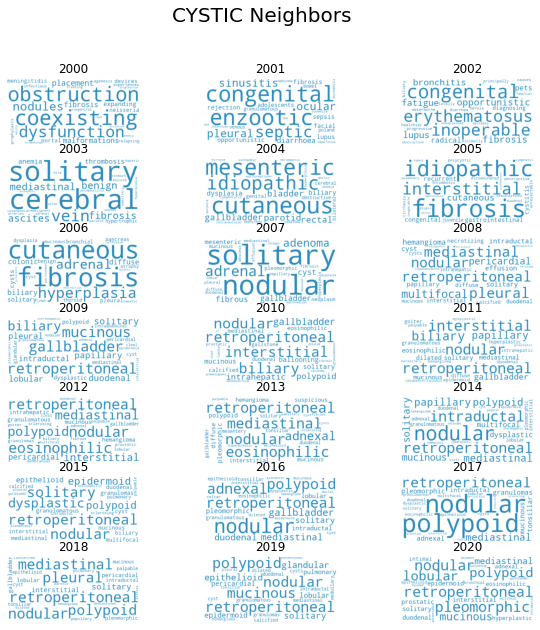

In [55]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/cystic.png"
)

## Cell

In [56]:
token_timeline_df = generate_timeline(year_comparison_dict, "cell")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
2855,cell,0.184355,0.021864,0.162492,2005_2006
2855,cell,0.406372,0.077244,0.329129,2019_2020
2855,cell,0.369117,0.070748,0.298369,2016_2017
2855,cell,0.344992,0.049223,0.295770,2007_2008
2855,cell,0.178217,0.015157,0.163060,2004_2005


In [57]:
token_timeline_low_dim_df = project_token_timeline(
    "cell", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.head()

,tsne_dim1,tsne_dim2,year,token,label
0,3.983836,1.678589,2020,cell,main
1,3.670978,1.738433,2020,cells,neighbor
2,3.121937,2.769867,2020,cellular,neighbor
3,1.995732,1.448298,2020,keratinocyte,neighbor
4,2.709045,1.242075,2020,hepatocyte,neighbor


In [58]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="cell"
)

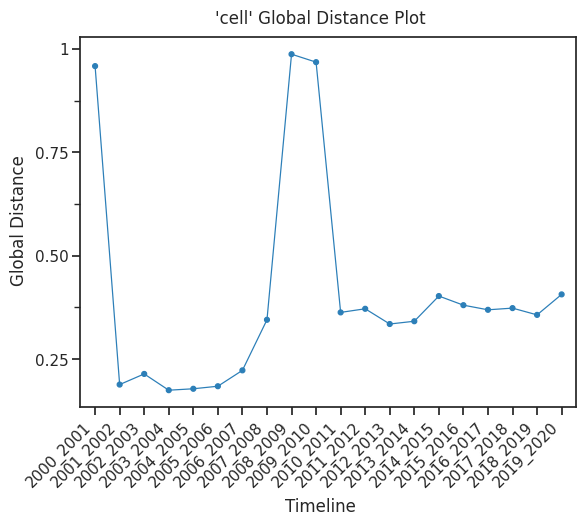

<ggplot: (-9223363250710348947)>

In [59]:
global_distance

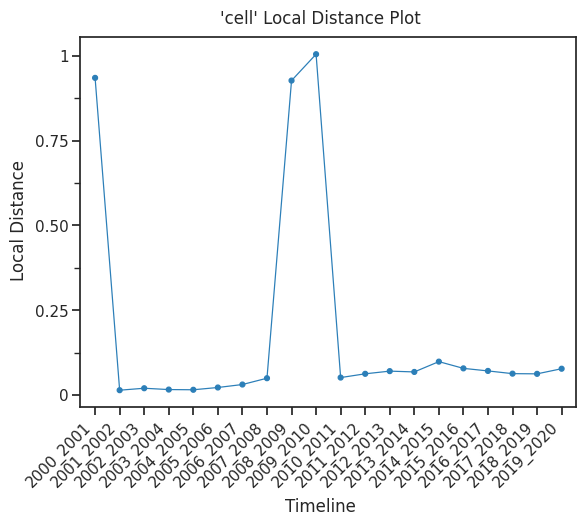

<ggplot: (8786145163840)>

In [60]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/celltime_plot.png


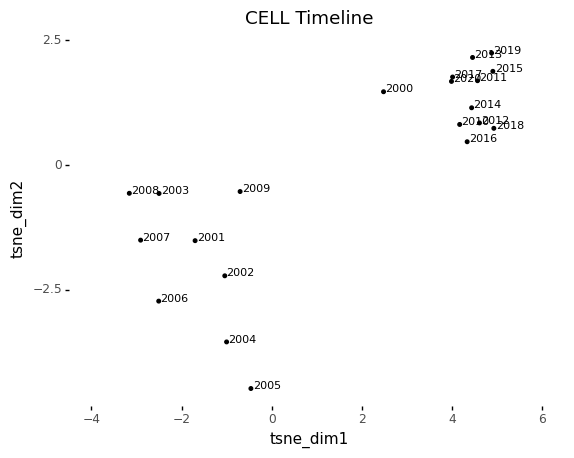

<ggplot: (8786152898757)>


In [61]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/figures/celltime_plot.png")
print(g)

In [62]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/cell.gif"
)

![cell gif here](output/wordcloud_plots/cell.gif)

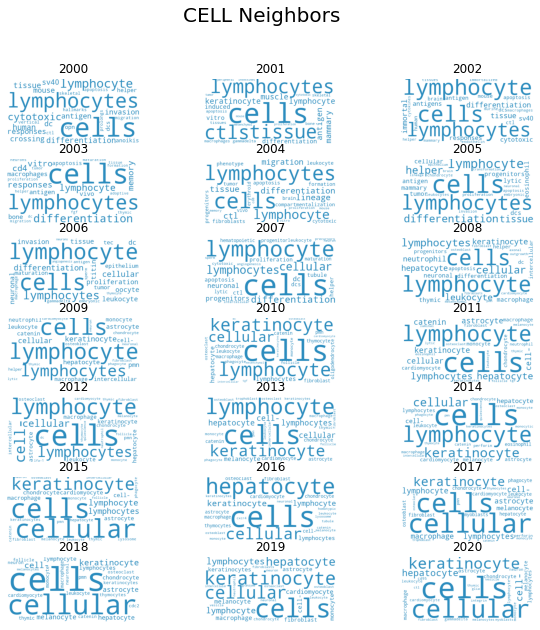

In [63]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots/cell.png"
)

# Conclusions - Take Home Point(s)

1. 2008 - 2010 has a huge spike in semantic change for all the tokens I have analyzed in this notebook
2. Plotting word clouds for the neighbor of each word highlights the shift these vectors are capturing
3. SpaCy likes to break hyphened words apart which makes capturing words such as RNA-seq and single-cell impossible to detect. Will need to update that if I want to have those words incorporated. Plus I need to use named entity recognition (NER tagger) to group nouns together as a high portion of biological terms are two words and not one.
4. Some words like cystic, p53, expression are able to show transitions in meaning which is nice. So there is some success here.